In [114]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

# 2. Importing Datasets:

Key considerations: Geographic alignment (e.g., location-specific data), economic indicators (e.g., market trends), or temporal trends (e.g., changes over time).

May work: Stock Market Performance of Construction or Real Estate Companies like Zillow, Redfin or Lennar. These companies often correlate their business success with housing trends, allowing you to connect housing demand and construction trends.

I Chose Zillow Data : Advanced real estate data : https://data.nasdaq.com/databases/ZILLOW

In [5]:
# Import the house sales data
path = r'C:\Users\hp\House Sales in King County, USA'
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'kc_house_data_for_visualizations.csv'), index_col = False)

In [7]:
data = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'ZILLOW_DATA.csv'))
regions = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'ZILLOW_REGIONS.csv'))

In [11]:
df.shape

(21612, 24)

In [13]:
data.shape

(155574532, 4)

In [15]:
regions.shape

(89305, 3)

In [17]:
data.head()

,indicator_id,region_id,date,value
0,Z4BR,65856,2018-02-28,509966.717868
1,Z4BR,94920,2018-02-28,393052.284119
2,Z4BR,63078,2018-02-28,89932.390841
3,Z4BR,73108,2018-02-28,219385.968716
4,Z4BR,77740,2018-02-28,218395.779920


In [19]:
regions.head()

,region_id,region_type,region
0,394415,metro,"Bridgeport, CT"
1,394653,metro,"Greenville, SC"
2,394312,metro,"Albuquerque, NM"
3,394357,metro,"Bakersfield, CA"
4,394308,metro,"Albany, NY"


# 3. Wragling Data

## 3.1 Data Subsetting:

In [23]:
# Create a subset from region data filtered to only show regions based on zip code
regions_zip = regions.loc[(regions['region_type'] == 'zip')]

In [25]:
regions_zip.head()

,region_id,region_type,region
154,58011,zip,00612; MI; Crawford County; Frederic
817,58051,zip,00693; PA; Pittsburgh; Westmoreland County; Gr...
1755,58109,zip,00795; AL; Auburn-Opelika; Lee County; Juana Diaz
2737,62046,zip,"11236;NY;New York-Newark-Jersey City, NY-NJ-PA..."
2738,61807,zip,"10467;NY;New York-Newark-Jersey City, NY-NJ-PA..."


In [27]:
# Get a list of unique zip codes
unique_zipcodes = df['zipcode'].unique()

# Display the zip codes
print(unique_zipcodes)

[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


In [29]:
# Zipcode is currently embedded as part of a string in the 'region' column. 
# We need to extract the zipcode and create a new column.
def extract_zip(region_str):
    first_part = region_str.split(';')[0]  # Split by ';' and take the first part
    if first_part.isdigit():  # Check if the first part is a number
        return int(first_part)
    return None  # Return None if it's not a ZIP code

# Apply the function to create a new 'zip_code' column
regions_zip['zip_code'] = regions_zip['region'].apply(extract_zip)

In [31]:
# Filter by desired ZIP codes
filtered_zip = regions_zip[regions_zip['zip_code'].isin(unique_zipcodes)]

# Print the filtered dataframe
filtered_zip.head()

,region_id,region_type,region,zip_code
42647,99534,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
43536,99565,zip,"98105;WA;Seattle-Tacoma-Bellevue, WA;Seattle;K...",98105
43549,99559,zip,"98092;WA;Seattle-Tacoma-Bellevue, WA;nan;King ...",98092
43578,99575,zip,"98115;WA;Seattle-Tacoma-Bellevue, WA;Seattle;K...",98115
43583,99508,zip,"98023;WA;Seattle-Tacoma-Bellevue, WA;Federal W...",98023


In [33]:
df_merged = data.merge(filtered_zip, on='region_id', how='inner')

# Check the result
print(f"Rows in merged DataFrame: {len(df_merged)}")
print(df_merged.head())

Rows in merged DataFrame: 198574
  indicator_id  region_id        date         value region_type  \
0         Z4BR      99502  2018-02-28  7.177322e+05         zip   
1         Z4BR      99498  2018-02-28  5.323760e+05         zip   
2         Z4BR      99509  2018-02-28  8.727700e+05         zip   
3         Z4BR      99524  2018-02-28  2.759595e+06         zip   
4         Z4BR      99534  2018-03-31  9.985806e+05         zip   

                                              region  zip_code  
0  98014;WA;Seattle-Tacoma-Bellevue, WA;Carnation...     98014  
1  98010;WA;Seattle-Tacoma-Bellevue, WA;Black Dia...     98010  
2  98024;WA;Seattle-Tacoma-Bellevue, WA;Fall City...     98024  
3  98039;WA;Seattle-Tacoma-Bellevue, WA;Medina;Ki...     98039  
4  98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...     98052  


In [35]:
df_merged.head()

,indicator_id,region_id,date,value,region_type,region,zip_code
0,Z4BR,99502,2018-02-28,7.177322e+05,zip,"98014;WA;Seattle-Tacoma-Bellevue, WA;Carnation...",98014
1,Z4BR,99498,2018-02-28,5.323760e+05,zip,"98010;WA;Seattle-Tacoma-Bellevue, WA;Black Dia...",98010
2,Z4BR,99509,2018-02-28,8.727700e+05,zip,"98024;WA;Seattle-Tacoma-Bellevue, WA;Fall City...",98024
3,Z4BR,99524,2018-02-28,2.759595e+06,zip,"98039;WA;Seattle-Tacoma-Bellevue, WA;Medina;Ki...",98039
4,Z4BR,99534,2018-03-31,9.985806e+05,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052


In [37]:
df_merged['indicator_id'].value_counts()

indicator_id
Z4BR    24010
ZSFH    24010
ZALL    24010
Z3BR    24010
Z5BR    23991
Z2BR    23981
Z1BR    22177
ZCON    22127
RSNA     5129
RSSA     5129
Name: count, dtype: int64

**Zillow indicators:**
- Z4BR	ZHVI 4-Bedroom Time Series
- ZSFH	ZHVI Single-Family Homes Time Series 
- ZALL	ZHVI All Homes (SFR, Condo/Co-op) Time Series 
- Z3BR	ZHVI 3-Bedroom Time Series 
- Z5BR	ZHVI 5+ Bedroom Time Series 
- Z2BR	ZHVI 2-Bedroom Time Series 
- Z1BR	ZHVI 1-Bedroom Time Series 
- ZCON	ZHVI Condo/Co-op Time Series 
- RSSA	ZORI (Smoothed, Seasonally Adjusted): All Homes Plus Multifamily Time Series 
- RSNA	ZORI (Smoothed): All Homes Plus Multifamily Time Series 

In [42]:
# Create subset including records where indicator_id == 'ZALL' 
df_merged2 = df_merged.loc[(df_merged['indicator_id'] == 'ZALL')]

In [44]:
df_merged2.head()

,indicator_id,region_id,date,value,region_type,region,zip_code
17941,ZALL,99534,1996-01-31,210783.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
17942,ZALL,99534,1996-02-29,210840.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
17943,ZALL,99534,1996-03-31,210858.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
17944,ZALL,99534,1996-04-30,210898.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
17945,ZALL,99534,1996-05-31,210905.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052


## 2.2 Data Cleaning: 

In [51]:
#Checking Duplicates 
dups = df_merged2[df_merged2.duplicated()]
print(dups)

Empty DataFrame
Columns: [indicator_id, region_id, date, value, region_type, region, zip_code]
Index: []


In [53]:
# Check for missing values
df_merged2.isnull().sum()

indicator_id    0
region_id       0
date            0
value           0
region_type     0
region          0
zip_code        0
dtype: int64

In [55]:
# Check for mixed-type data
for col in df_merged2.columns.tolist():
  weird = (df_merged2[[col]].map(type) != df_merged2[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df_merged2[weird]) > 0:
    print (col)

In [47]:
df_merged2.dtypes

indicator_id     object
region_id         int64
date             object
value           float64
region_type      object
region           object
zip_code          int64
dtype: object

In [49]:
# Convert 'date' to datetime format
df_merged2['date'] = pd.to_datetime(df_merged2['date'])

In [58]:
df_merged2.dtypes

indicator_id            object
region_id                int64
date            datetime64[ns]
value                  float64
region_type             object
region                  object
zip_code                 int64
dtype: object

In [60]:
# Group by 'date' and calculate the mean value for each date
kc_prices = df_merged2.groupby('date')['value'].mean().reset_index()

In [62]:
kc_prices.head()

,date,value
0,1996-01-31,200653.528571
1,1996-02-29,200793.228571
2,1996-03-31,200839.600000
3,1996-04-30,200881.542857
4,1996-05-31,200893.000000


In [64]:
kc_prices.describe()

,date,value
count,343,3.430000e+02
mean,2010-04-30 22:15:02.623906816,4.994235e+05
min,1996-01-31 00:00:00,2.006535e+05
25%,2003-03-15 12:00:00,3.346294e+05
50%,2010-04-30 00:00:00,4.340844e+05
75%,2017-06-15 00:00:00,6.253778e+05
max,2024-07-31 00:00:00,1.101726e+06
std,NaN,2.287791e+05


In [66]:
# Seting the "Date" column as the index
from datetime import datetime
kc_prices['datetime'] = pd.to_datetime(kc_prices['date']) # Create a datetime column from "date"
kc_prices = kc_prices.set_index('datetime') # Set the datetime as the index of the dataframe
kc_prices.drop(['date'], axis=1, inplace=True) # Drop the "date" column
kc_prices.head()

,value
datetime,
1996-01-31,200653.528571
1996-02-29,200793.228571
1996-03-31,200839.600000
1996-04-30,200881.542857
1996-05-31,200893.000000


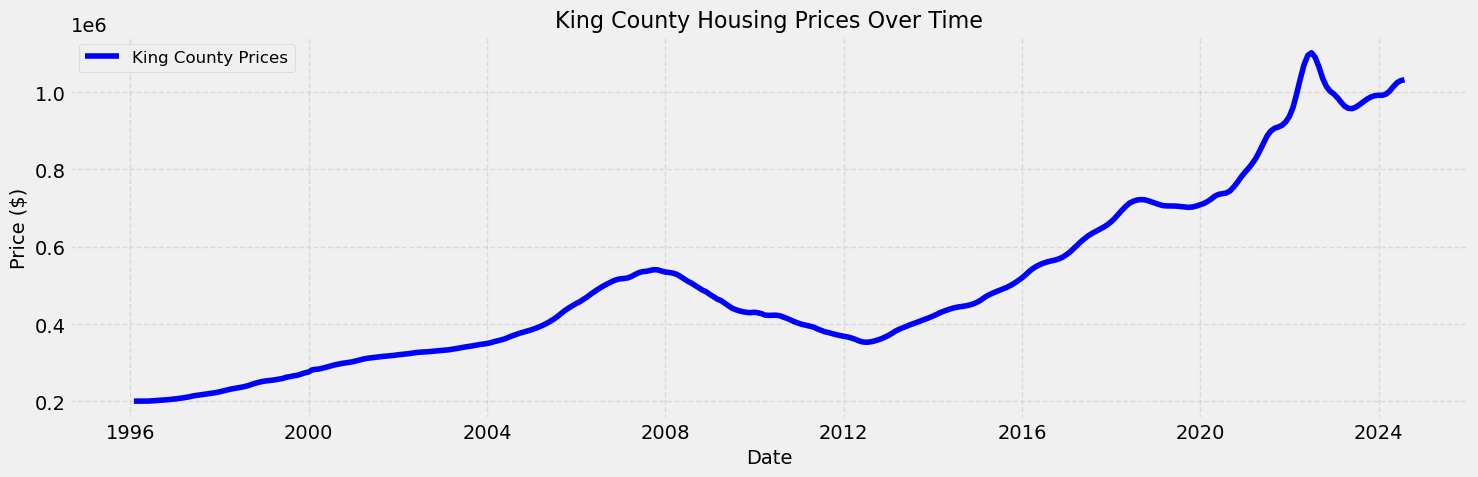

In [70]:
# Plot the data
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(kc_prices, color='blue', label='King County Prices')

# Enhancing the plot
plt.title('King County Housing Prices Over Time', fontsize=16)  # Add a title
plt.xlabel('Date', fontsize=14)  # Label the x-axis
plt.ylabel('Price ($)', fontsize=14)  # Label the y-axis
plt.grid(visible=True, linestyle='--', alpha=0.6)  # Add a light grid
plt.legend(loc='upper left', fontsize=12)  # Add a legend
plt.tight_layout()  # Adjust layout to prevent cutoff of labels

# Display the plot
plt.show()

$ Insights $ 

The figure depicts the trend of housing prices in King County over time, using Zillow's Home Value Index (ZHVI) for all homes. It highlights a steady rise in prices from the late 1990s until the peak around 2007, followed by a sharp decline during the 2008 financial crisis. The market subsequently rebounded strongly, particularly after 2012, with a consistent upward trend that reflects increasing demand and limited housing supply.

More recently, there is evidence of rapid growth starting in 2020, likely fueled by the pandemic-related housing boom driven by low-interest rates, increased remote work, and higher demand for suburban homes. While the trend appears to stabilize post-2022, prices remain significantly higher than pre-pandemic levels, emphasizing King County's growing appeal as a desirable housing market.

# 3. Time-series analysis: decomposition

In [79]:
# Decompose the data's components
decomposition = sm.tsa.seasonal_decompose(kc_prices, model='additive')

In [81]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

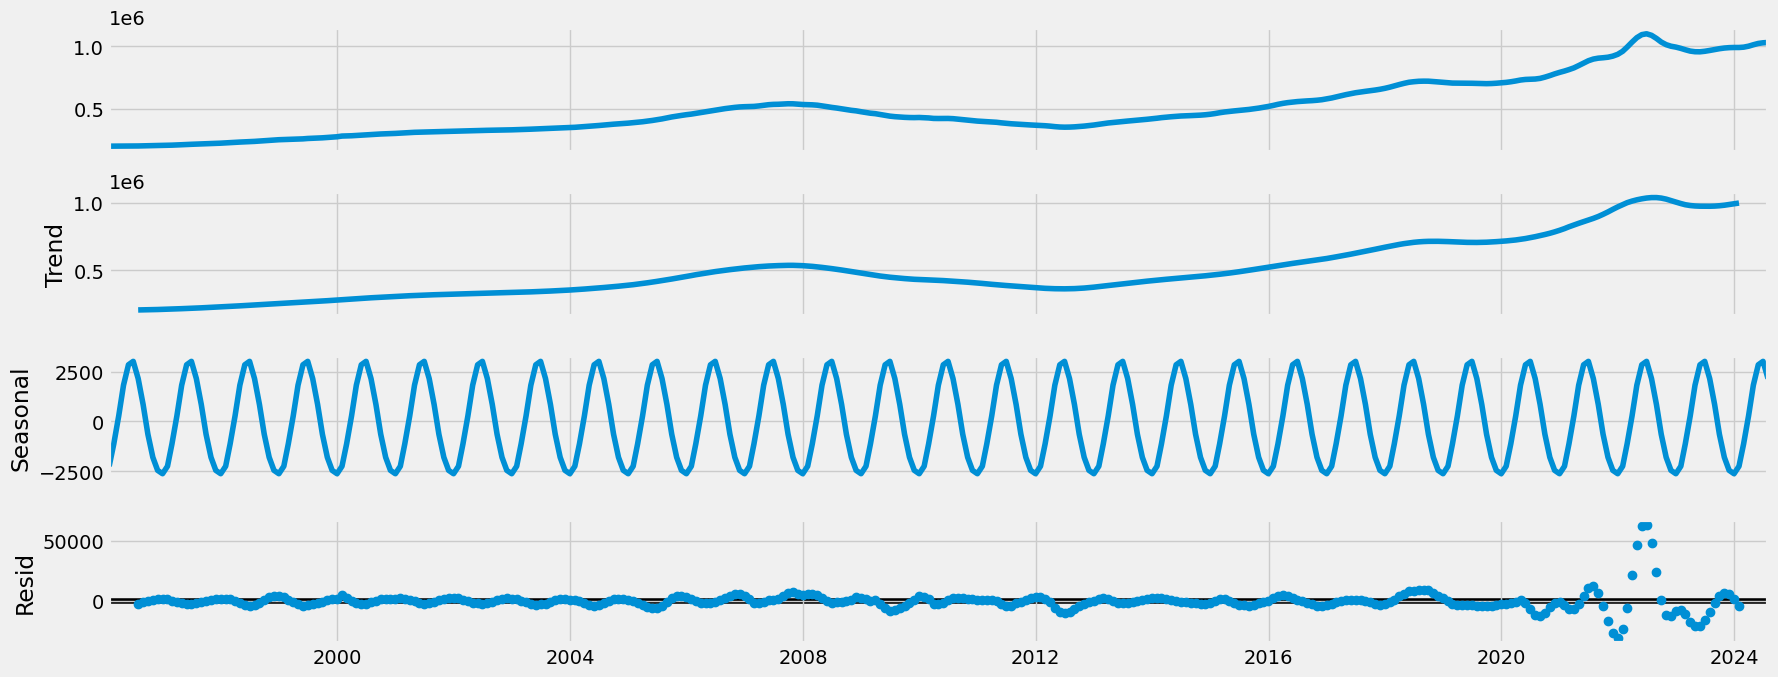

In [83]:
# Plot the separated components
decomposition.plot()
plt.show()

$ Insights: $
The decomposition plot provides a detailed analysis of the housing price data by breaking it down into its level, trend, seasonal, and residual components:

##### Level: 
The top plot represents the raw data, combining all components. It reflects the overall trajectory of King County housing prices, including both long-term growth and short-term fluctuations.

##### Trend: 
The second plot shows the underlying upward trend, indicating that housing prices have generally increased over the years. Despite minor declines (e.g., the 2008 financial crisis), the long-term growth trend is clear, particularly after 2020.

##### Seasonality: 
The third plot highlights the recurring seasonal patterns. These yearly cycles suggest predictable fluctuations, likely tied to the timing of buying and selling activity in the housing market (e.g., higher activity during spring and summer).

##### Residuals (Noise): 
The bottom plot shows the residual or unexplained variation in the data after accounting for the trend and seasonality. While relatively low for most of the timeline, the residuals increase significantly post-2020, potentially due to external shocks like the COVID-19 pandemic, which disrupted real estate markets.

##### Key Takeaway:
The data exhibits both a clear upward trend and significant seasonality, classifying it as non-stationary. This suggests that any predictive modeling should account for these patterns. The residual spikes post-2020 highlight the need to consider external factors in recent years when interpreting or forecasting housing price trends.

# 4. Testing for stationarity

In [97]:
# Conduct a Dickey-Fuller test to check for stationarity

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)

# Apply the test on the time series
dickey_fuller(kc_prices['value'])

Dickey-Fuller Stationarity Test:
Test Statistic                   0.539129
p-value                          0.986015
Number of Lags Used              8.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


##### Null Hypothesis:
The null hypothesis (H₀) of the Dickey-Fuller test states that the time series is non-stationary, meaning it has a unit root. If the null hypothesis is rejected, it implies that the series is stationary.

##### Results:
- Critical Values: The test compares the test statistic with critical values at 1%, 5%, and 10% significance levels.
##### Interpretation:
- If the test statistic is less than the critical value, and the p-value is less than 0.05, we reject the null hypothesis, concluding that the series is stationary.
- If the test statistic is greater than the critical value, and the p-value is greater than 0.05, we fail to reject the null hypothesis, meaning the series is non-stationary.
##### From the earlier results:
The test statistic (0.539129) is greater than all critical values, and the p-value (0.986015) is significantly higher than 0.05.
Conclusion: We fail to reject the null hypothesis, indicating that the data is non-stationary.

# 5. Stationarizing the Zillow Real Estate Data

In [101]:
# Stationarize the data by using the differencing technique
data_diff = kc_prices - kc_prices.shift(1)
# Remove any mising values as a result of the differencing
data_diff.dropna(inplace=True)

In [103]:
data_diff.head()

,value
datetime,
1996-02-29,139.700000
1996-03-31,46.371429
1996-04-30,41.942857
1996-05-31,11.457143
1996-06-30,628.300000


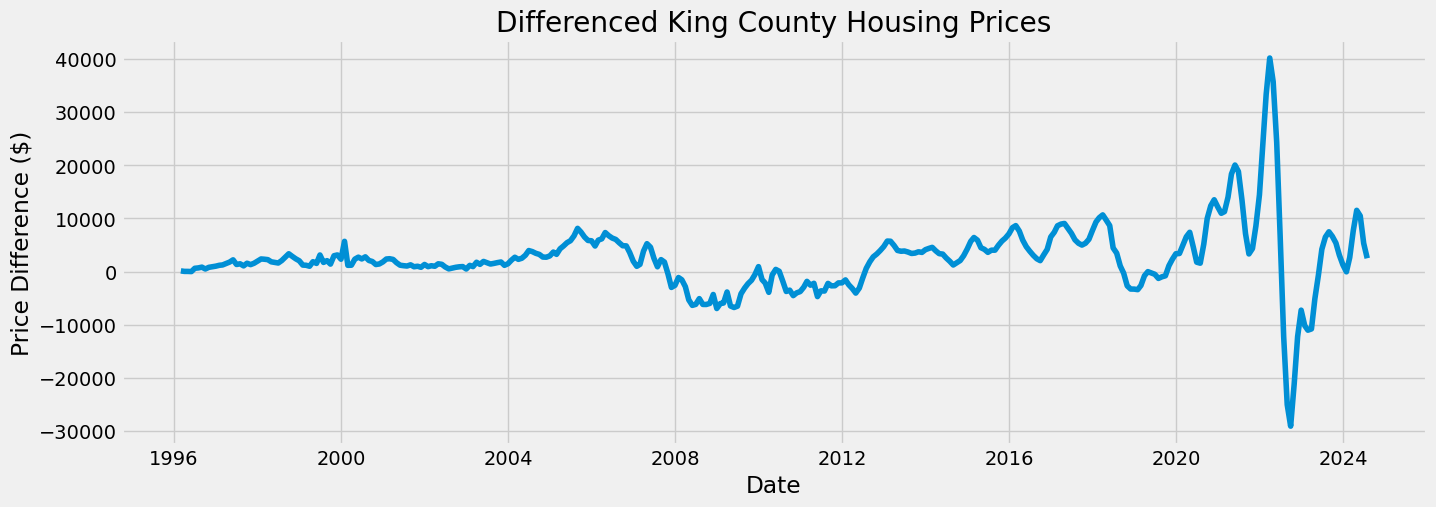

Test Statistic: -4.560574910516898
p-value: 0.00015259779563423555


In [105]:
# Plot the differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
plt.title('Differenced King County Housing Prices')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.show()

# Perform Dickey-Fuller test on differenced data
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(data_diff)
print(f"Test Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")

In [109]:
# Recheck for stationarity by running another Dickey_Fuller test
dickey_fuller(data_diff['value'])

Dickey-Fuller Stationarity Test:
Test Statistic                  -4.560575
p-value                          0.000153
Number of Lags Used              7.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


##### Null Hypothesis (H₀): 
The data has a unit root, meaning the series is non-stationary.
##### Alternative Hypothesis (H₁): 
The data does not have a unit root, implying that the series is stationary.

Since the test statistic (-4.560575) is more negative than the critical values at 1%, 5%, and 10%, and the p-value (0.000153) is much lower than 0.05, we reject the null hypothesis.

##### Conclusion:
The data is stationary after differencing, as we have statistically rejected the null hypothesis of a unit root. This indicates that the differenced King County housing prices do not exhibit a trend over time and are ready for modeling techniques that require stationary data.



<Figure size 1200x600 with 0 Axes>

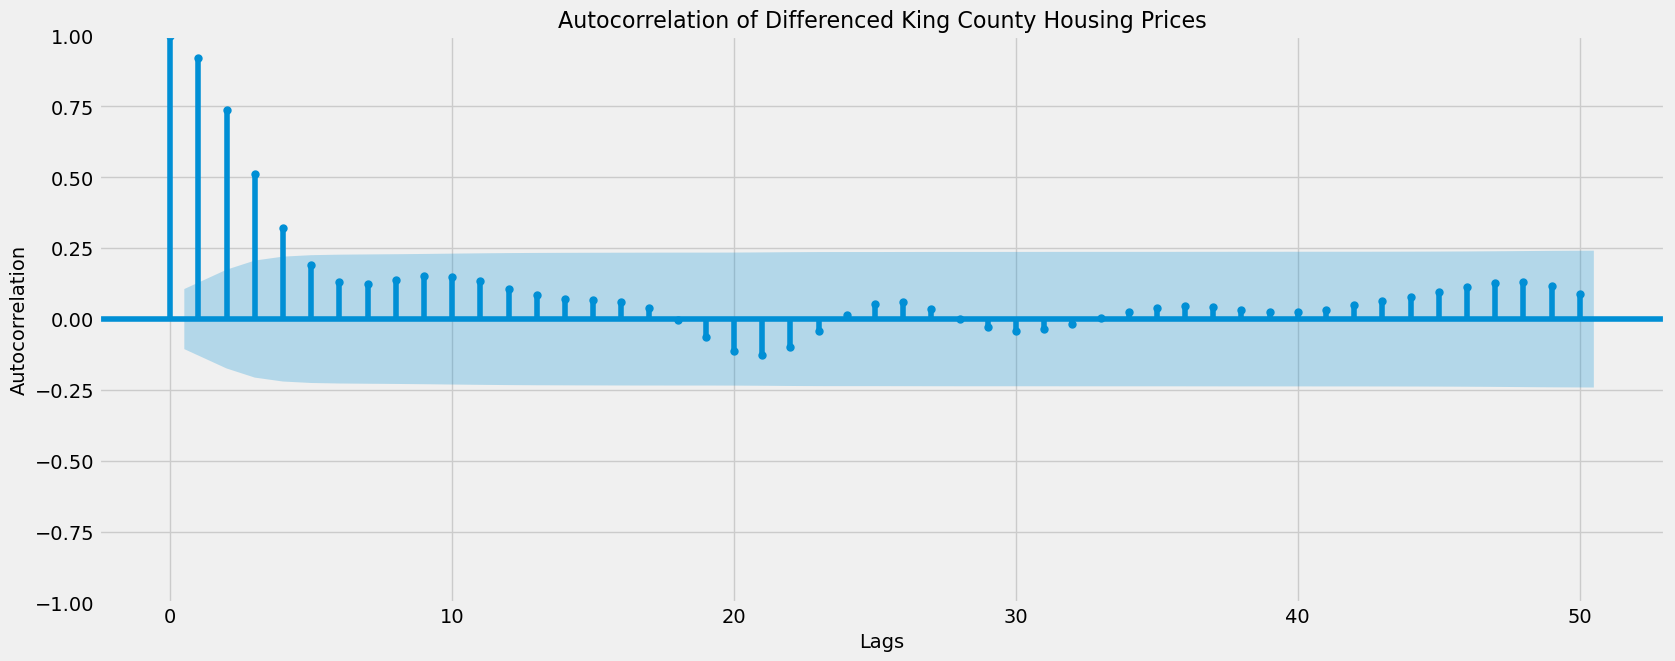

In [118]:
# Check for autocorrelations
plt.figure(figsize=(12, 6))  # Increase figure size for better clarity
plot_acf(data_diff, lags=50)  # Limit to 50 lags (can be adjusted)
plt.title('Autocorrelation of Differenced King County Housing Prices', fontsize=16)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.grid(True)  # Add gridlines for better readability
plt.show()